In [107]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.mixture import GaussianMixture
import math
import qgrid
import scipy as sc
from scipy import stats
%matplotlib inline

### Leer datos

In [108]:
PATHDATA = 'audiosData.csv'
data = pd.read_csv(PATHDATA)
data = data.values #Convertimos en un  numpy array

### Dividir el dataset usando GroupKFold

In [149]:
FOLDS = 15
X = data[:,0:-2]
Y = data[:,-1]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-2:-1]
group_kfold = GroupKFold(n_splits=FOLDS)
group_kfold.get_n_splits(X, Y, groups)
cont = 0
for train_index, test_index in group_kfold.split(X, Y, groups):
    print('FOLD',cont,"TRAIN:", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    cont= cont +1

Tamaño dataSet (5199, 162)


FOLD 0 TRAIN: (4852,) TEST: (347,)
FOLD 1 TRAIN: (4852,) TEST: (347,)
FOLD 2 TRAIN: (4852,) TEST: (347,)
FOLD 3 TRAIN: (4852,) TEST: (347,)
FOLD 4 TRAIN: (4852,) TEST: (347,)
FOLD 5 TRAIN: (4852,) TEST: (347,)
FOLD 6 TRAIN: (4852,) TEST: (347,)
FOLD 7 TRAIN: (4852,) TEST: (347,)
FOLD 8 TRAIN: (4852,) TEST: (347,)
FOLD 9 TRAIN: (4853,) TEST: (346,)
FOLD 10 TRAIN: (4853,) TEST: (346,)
FOLD 11 TRAIN: (4853,) TEST: (346,)
FOLD 12 TRAIN: (4853,) TEST: (346,)
FOLD 13 TRAIN: (4853,) TEST: (346,)
FOLD 14 TRAIN: (4853,) TEST: (346,)


In [100]:
X.max(),X.min()

(14.696712493896483, -23.02585220336914)

### GMM

In [177]:
def GMMClassifierTrain(X,Y,M,tipo):    
    #X: Matriz con las características
    #Y: Matriz con las clases
    #M: Número de componentes
    #tipo: Tipo de matriz de covarianza
    nClases = np.unique(Y)
    GMMs = [] # Vector que tiene los modelos GMM entrendao
    for c in nClases:
        gmm = GaussianMixture(M,tipo)#Configurar el modelo
        Xc = X[Y==c] # Seleccionamos la matrix de la clase a entrenar
        GMMs.append(gmm.fit(Xc))        
    return GMMs #Debe retornar un objeto que contenga todos los modelos entrenados

def GMMClassfierVal(GMMs,Xtest):
    nGmm = len(GMMs) #Numero de modelos que existen
    nSamples = len(Xtest) #Numero de muestras a clasificar
    """Creamos una matriz de tamaño nSamples,nGmm en donde
    cada valor de la columna representa la probabilidad de que esta muestra pertenezca a dicha clase
    la pocision del mayor valor de la columna es la clase a la que se predice pertenecera
    """
    mProbabilities = np.zeros((nSamples,nGmm))
    for i in range(nGmm):
        mProbabilities[:,i]=GMMs[i].score_samples(Xtest)
    Yest = np.argmax(mProbabilities,axis=1)    
    return Yest #Debe retornar un vector con las clases predichas para cada una de las muestras en Xtest, de acuerdo con los modelos almacenados en GMMs

In [178]:
#Normalizamos los datos
def normalize(Xtrain,Xtest):
    media = np.mean(Xtrain)
    desvia = np.std(Xtrain)
    Xtrain = sc.stats.stats.zscore(Xtrain)
    Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)
    return Xtrain,Xtest

In [197]:
covNameSklearn = ['full','tied','diag','spherical']
#M: Número de componentes
def impletationGMMTrain(sizeData, M, typeM):
    FOLDS = 15
    X = data[0:sizeData,0:-2]
    Y = data[0:sizeData,-1]
    #Y=  np.reshape(Y,(np.size(Y,0),1))
    groups = data[0:sizeData,-2:-1]
    group_kfold = GroupKFold(n_splits=FOLDS)
    group_kfold.get_n_splits(X, Y, groups)
    EfficiencyTrain = np.zeros(FOLDS)
    EfficiencyVal = np.zeros(FOLDS)
    j = 0    
    for train_index, test_index in group_kfold.split(X, Y, groups):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]    
        X_train,X_test = normalize(X_train,X_test)
        gmms = GMMClassifierTrain(X_train,Y_train,M,typeM)
        
        #GUARDAR ESTE MODELO ENTRENADO
        
        
        #
        #Validación
        Ytrain_pred = GMMClassfierVal(gmms,X_train);
        Yesti = GMMClassfierVal(gmms,X_test);

        #Evaluamos las predicciones del modelo con los datos de Y_test
        EfficiencyTrain[j] = np.mean(Ytrain_pred.ravel() == Y_train.ravel())
        EfficiencyVal[j] = np.mean(Yesti.ravel() == Y_test.ravel())
        j += 1
        # Eficiencia promedio VALIDACION --> np.mean(EficienciaVal) e Intervalo de confianza ---> np.std(EficienciaVal)
        # Eficiencia promedio ENTRENAMIENTO --> np.mean(EfficiencyTrain) e Intervalo de confianza ---> np.std(EfficiencyTrain)        
    return np.mean(EfficiencyTrain),np.std(EfficiencyTrain),np.mean(EfficiencyVal),np.std(EfficiencyVal)

In [183]:
#! pip install qgrid

In [184]:
import numpy.matlib as npm

df_types = pd.DataFrame({
    'Matriz de covarianza' : pd.Series(['full','full','full','full','full','full','diag','diag','diag','diag','diag','diag','spherical','spherical','spherical','spherical','spherical','spherical','tied','tied','tied','tied','tied','tied']),
    'Numero de componentes' : pd.Series([1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6])})
df_types["Eficiencia en Validacion"] = ""
df_types["Intervalo de confianza en Validacion"] = ""
df_types["Eficiencia en Entrenamiento"] = ""
df_types["Intervalo de confianza Entrenamiento"] = ""
df_types.set_index(['Matriz de covarianza','Numero de componentes'], inplace=True)
cont = 0
for tipo,m in df_types.index:
    EfficiencyTrain,intervalsTrain,EfficiencyVal, intervalsVal =impletationGMMTrain(5199,int(m),tipo)
    df_types["Eficiencia en Validacion"][cont] = str(EfficiencyTrain)
    df_types["Intervalo de confianza en Validacion"][cont] = str(intervalsTrain)
    df_types["Eficiencia en Entrenamiento"][cont] =str(EfficiencyVal)
    df_types["Intervalo de confianza Entrenamiento"][cont] =str(intervalsVal)
    cont = cont +1
df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget
qgrid_widget.get_changed_df()

Eficiencia en Validacion  \
Matriz de covarianza Numero de componentes                            
diag                 1                           0.4753523670097061   
                     2                          0.47645065559490796   
                     3                           0.5185335423699129   
                     4                           0.5348140298674973   
                     5                           0.5449122928016071   
                     6                           0.5523043683809353   
full                 1                            0.930439938308275   
                     2                           0.9627265372209517   
                     3                           0.9871816681103192   
                     4                             0.99117961160623   
                     5                            0.993638820849321   
                     6                           0.9965515023244248   
spherical            1                           0.4463632357680183   
                     2                          0.45507350283552156   
                     3                          0.49307552740315186   
                     4                           0.5103591198153439   
                     5                           0.5211988663463168   
                     6                           0.5286456359423779   
tied                 1                            0.930439938308275   
                     2                           0.9316489824189228   
                     3                           0.9331189909981655   
                     4                           0.9340257882373832   
                     5                           0.9344242238718573   
                     6                           0.9352760524634475   

                                           Intervalo de confianza en Validacion  \
Matriz de covarianza Numero de componentes                                        
diag                 1                                    0.0024939855325870797   
                     2                                      0.01319451292035803   
                     3                                     0.020054014750590342   
                     4                                     0.016310167455941597   
                     5                                     0.010324954942477404   
                     6                                     0.011737015106388573   
full                 1                                    0.0021541360614395176   
                     2                                     0.007212187614757708   
                     3                                    0.0014627328583245473   
                     4                                    0.0009702616608530562   
                     5                                    0.0018631400442597203   
                     6                                    0.0014347142268608859   
spherical            1                                     0.002536497505770856   
                     2                                     0.013072470724891127   
                     3                                     0.009490826556462351   
                     4                                     0.006666020142280764   
                     5                                     0.009975839036432458   
                     6                                     0.007117512418601794   
tied                 1                                    0.0021541360614395176   
                     2                                     0.002460031498105405   
                     3                                    0.0022019560402575895   
                     4                                    0.0021450285790014217   
                     5                                      0.00195317185036655   
                     6                                     0.002382668767799765   

                                     

In [187]:
df_types.to_csv('dataFrameGMM.csv')

In [195]:
df_types2 = pd.read_csv('dataFrameGMM.csv')
qgrid_widget = qgrid.show_grid(df_types2, show_toolbar=False)
qgrid_widget
qgrid_widget.get_changed_df()


,Matriz de covarianza,Numero de componentes,Eficiencia en Validacion,Intervalo de confianza en Validacion,Eficiencia en Entrenamiento,Intervalo de confianza Entrenamiento
0,diag,1,0.475352,0.002494,0.336799,0.031620
1,diag,2,0.476451,0.013195,0.326427,0.032425
2,diag,3,0.518534,0.020054,0.311617,0.030241
3,diag,4,0.534814,0.016310,0.281010,0.034138
4,diag,5,0.544912,0.010325,0.282742,0.037807
5,diag,6,0.552304,0.011737,0.283331,0.038306
6,full,1,0.930440,0.002154,0.666080,0.029079
7,full,2,0.962727,0.007212,0.699562,0.031074
8,full,3,0.987182,0.001463,0.702440,0.032116
9,full,4,0.991180,0.000970,0.668581,0.025490


### Construcción de la curva de aprendizaje

In [200]:
def plot_learning_curves(X_train, suptitle='', title='', xlabel='Training setSize', ylabel='Acurracy'):
    """
    Parameters
    ----------
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []

    # create ten incremental training set sizes
    training_set_sizes = np.linspace(100, len(X_train), 10, dtype='int')

    # for each one of those training set sizes
    for i in training_set_sizes:
        EfficiencyTrain,intervalsTrain,EfficiencyVal, intervalsVal =impletationGMMTrain(i,3,'full')    
        # store the scores in their respective lists
        train_score.append(EfficiencyTrain)
        val_score.append(EfficiencyVal)
        
    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['training set', 'validation set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = FuncFormatter(percentages)
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = FuncFormatter(numbers)
    ax.xaxis.set_major_formatter(x_formatter)

NameError: name 'FuncFormatter' is not defined

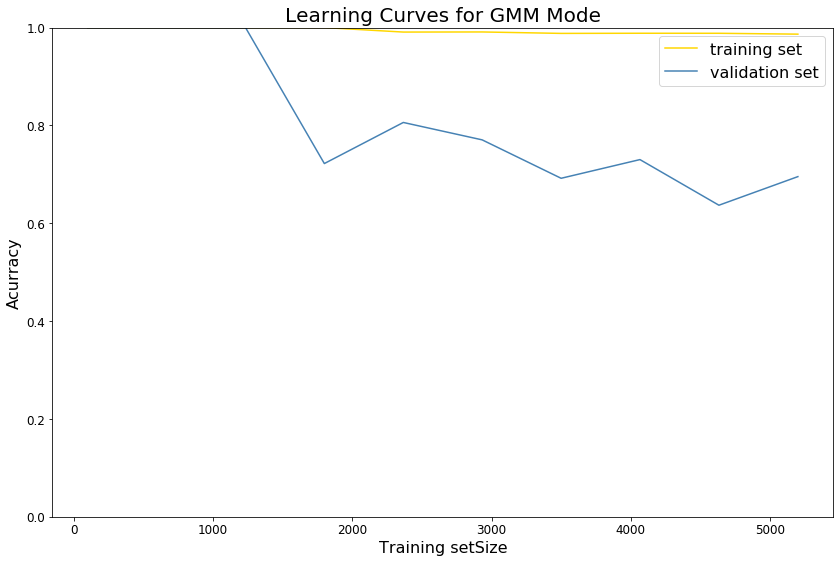

In [201]:
plot_learning_curves(X, suptitle='', title='Learning Curves for GMM Mode', xlabel='Training setSize', ylabel='Acurracy')